# Imports

In [1]:
import sys
sys.path

['/home/poul/micromamba/envs/dpg25/lib/python311.zip',
 '/home/poul/micromamba/envs/dpg25/lib/python3.11',
 '/home/poul/micromamba/envs/dpg25/lib/python3.11/lib-dynload',
 '',
 '/home/poul/.local/lib/python3.11/site-packages',
 '/home/poul/micromamba/envs/dpg25/lib/python3.11/site-packages',
 '/home/poul/micromamba/envs/dpg25/lib/python3.11/site-packages/maxvolpy-0.3.8-py3.11-linux-x86_64.egg']

In [2]:
sys.path.insert(0, '..') # adds pyironflow

In [3]:
from pyiron_workflow import Workflow
from pyiron_nodes.atomistic.thermodynamics.landau.phases import LinePhase, IdealSolution, TemperatureLinePhase, PhasesFromDataFrame
from pyiron_nodes.atomistic.thermodynamics.landau.plot import TransitionTemperature, CalcPhaseDiagram, PlotConcPhaseDiagram, PlotMuPhaseDiagram, PlotIsotherms, PlotPhiMuDiagram, CheckTemperatureInterpolation
from pyiron_nodes.utilities import List5, Linspace, ReadDataFrame

In [4]:
from pyironflow import PyironFlow

# Melting Point

In [5]:
wf = Workflow('LANDAU_Melting', delete_existing_savefiles=True)
wf.liquid = LinePhase("liquid", 0.0, 2.50, 1e-4)
wf.solid = LinePhase("solid", 0.0, 2.45, 1e-5)
wf.melting = TransitionTemperature(wf.liquid, wf.solid, Tmin=300, Tmax=1500)

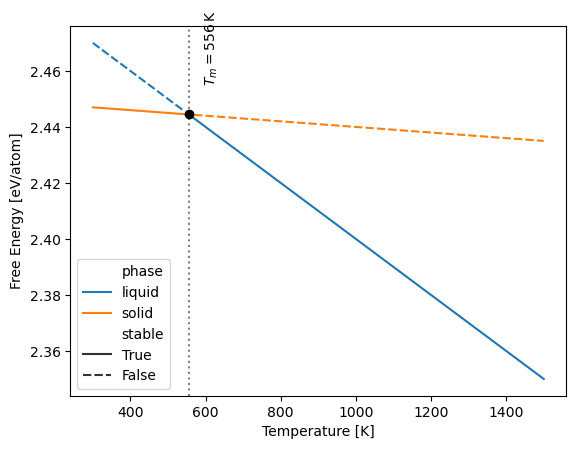

555.5555555555525

In [6]:
wf.melting.pull()

In [7]:
pf = PyironFlow([wf])
pf.gui

# Binary Phase Diagram

In [5]:
import numpy as np

In [6]:
wf = Workflow('LANDAU_BinaryPhaseDiagram', delete_existing_savefiles=True)
wf.liquid_a = LinePhase("liquid_a", 0.0, 2.50, 1e-4)
wf.liquid_b = LinePhase("liquid_b", 1.0, 3.10, 2e-4)
wf.liquid = IdealSolution("liquid", wf.liquid_a, wf.liquid_b)
wf.solid_a = LinePhase("solid_a", 0.0, 2.45, 1e-5)
wf.solid_b = LinePhase("solid_b", 1.0, 2.95, 1e-5)
wf.phases = List5(wf.liquid, wf.solid_a, wf.solid_b)
wf.linspace = Linspace(250, 1500, 100)
wf.phasedata = CalcPhaseDiagram(wf.phases, wf.linspace)
wf.diagram = PlotConcPhaseDiagram(wf.phasedata, plot_samples=True, plot_isolines=False)
wf.mudiagram = PlotMuPhaseDiagram(wf.phasedata)
wf.mucdiagram = PlotIsotherms(wf.phasedata)
wf.phimudiagram = PlotPhiMuDiagram(wf.phasedata)

/home/poul/micromamba/envs/dpg25/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


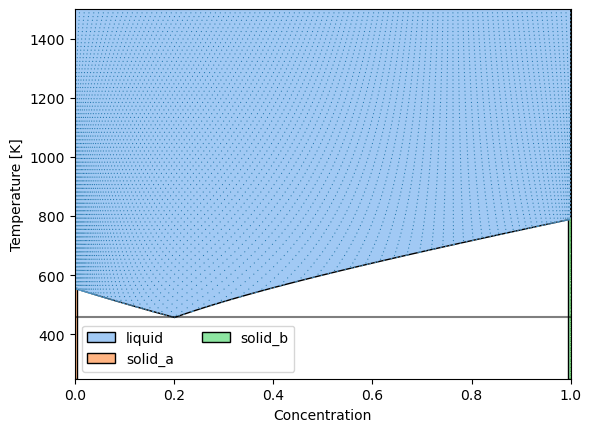

In [7]:
wf.diagram.pull()

In [8]:
pf = PyironFlow([wf])
pf.gui

In [12]:
wf.phasedata.use_cache

True

In [14]:
wf.phasedata._cached_inputs = {}

In [16]:
wf.phasedata._cached_inputs

{'phases': [IdealSolution(name='liquid', phase1=LinePhase(name='liquid_a', fixed_concentration=0.0, line_energy=2.5, line_entropy=0.0001), phase2=LinePhase(name='liquid_b', fixed_concentration=1.0, line_energy=3.1, line_entropy=0.0002)),
  LinePhase(name='solid_a', fixed_concentration=0.0, line_energy=2.45, line_entropy=1e-05),
  LinePhase(name='solid_b', fixed_concentration=1.0, line_energy=2.95, line_entropy=1e-05)],
 'temperatures': array([ 250.        ,  262.62626263,  275.25252525,  287.87878788,
         300.50505051,  313.13131313,  325.75757576,  338.38383838,
         351.01010101,  363.63636364,  376.26262626,  388.88888889,
         401.51515152,  414.14141414,  426.76767677,  439.39393939,
         452.02020202,  464.64646465,  477.27272727,  489.8989899 ,
         502.52525253,  515.15151515,  527.77777778,  540.4040404 ,
         553.03030303,  565.65656566,  578.28282828,  590.90909091,
         603.53535354,  616.16161616,  628.78787879,  641.41414141,
         654.0404

In [15]:
df= wf.phasedata.pull()

In [ ]:
import landau as ld

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ld.plot_phase_diagram(df, tielines=True)
for T, dd in df.query('refined=="delaunay-triple"').groupby('T'):
    plt.plot(dd.c, [T]*3, c='k', alpha=.5)

# Mg/Ca

https://github.com/eisenforschung/mgalca-mtp-data

In [7]:
import numpy as np
import pandas as pd
import landau

In [10]:
import matplotlib.pyplot as plt

In [11]:
import seaborn as sns

## Melting Point of Intermetallic

In [5]:
from pyiron_nodes.utilities import GetItem

In [12]:
wf = Workflow("LANDAU_Mg2Ca", delete_existing_savefiles=False)
if not wf.has_saved_content():
    wf.ReadDataFrame = ReadDataFrame("data/MgCaFreeEnergies.pckl.gz", "gzip")
    wf.Phases = PhasesFromDataFrame(wf.ReadDataFrame)
    # TODO: Which one is more intuitive?
    wf.Intermetallic = GetItem(wf.Phases.outputs.phase_dict, "Mg$_2$Ca")
    wf.Liquid = wf.Phases.outputs.phase_dict["liquid"]
    # controlling dmu allows finding non-congruent melting temperatures with the mixing liquid,
    # but maybe that's a bit technical
    wf.Melting = TransitionTemperature(wf.Intermetallic, wf.Liquid, Tmin=500, Tmax=1200, dmu=-0.65)

In [13]:
pf = PyironFlow([wf])
pf.gui

In [14]:
wf.save()

## Phasediagram

In [15]:
wf = Workflow("LANDAU_MgCa_Phasediagram", delete_existing_savefiles=False)
if not wf.has_saved_content():
    wf.ReadDataFrame = ReadDataFrame("data/MgCaFreeEnergies.pckl.gz", "gzip")
    wf.Phases = PhasesFromDataFrame(wf.ReadDataFrame, temperature_parameters=4)
    wf.Temperatures = Linspace(200, 1200, 50)
    wf.phasedata = CalcPhaseDiagram(wf.Phases.outputs.phase_list, wf.Temperatures, chemical_potentials=50)
    wf.diagram = PlotConcPhaseDiagram(wf.phasedata, plot_samples=True, plot_isolines=False)
    wf.mudiagram = PlotMuPhaseDiagram(wf.phasedata)
    wf.mucdiagram = PlotIsotherms(wf.phasedata)
    wf.phimudiagram = PlotPhiMuDiagram(wf.phasedata)

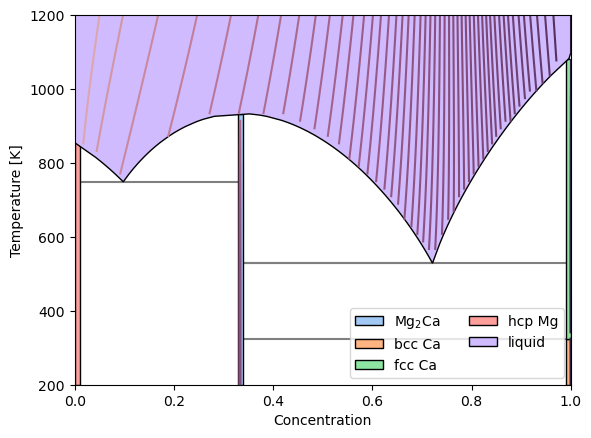

In [16]:
wf.diagram.pull()

In [17]:
PyironFlow([wf]).gui

In [18]:
wf.save()